In [2311]:
%reset -f

In [2312]:
#!/usr/bin/env python3
import pandas as pd
pd.set_option('display.max_rows', 10)
from typing import Union
import numpy as np
from tqdm import tqdm
import torch
from torch import nn
import re
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,10)
from torchmetrics import MeanAbsolutePercentageError
torch.manual_seed(42)
import random

In [2313]:
from scipy.signal import find_peaks

In [2314]:
import bz2
import pickle
import _pickle as cPickle

# Load any compressed pickle file
def decompress_pickle(filename):
    data = bz2.BZ2File(filename, 'rb')
    data = cPickle.load(data)
    return data

In [2315]:
# Pickle a file and then compress it into a file with extension 
def compressed_pickle(title, data):
    with bz2.BZ2File(title + '.pbz2', 'w') as f: 
        cPickle.dump(data, f)

In [2316]:
def make_dataframe_from_data(data:dict)->pd.DataFrame:
    dataframe = pd.DataFrame(data=data)
    return dataframe

In [2317]:
def get_simulation_data_from_file(filename:str)->pd.DataFrame:
    line_number = 1
    simulation_parameter_counter = 1
    a_spectrum_counter = 1
    b_spectrum_counter = 1

    lambdas = []
    trans = []

    thetas = []
    pitchs = []
    duty_cycles = []
    fill_factors =[]
    simulations = []
    simulation = 1

    num_lines = sum(1 for line in open(filename,'r'))
    with open(filename, 'r') as file:
        for line in tqdm(file, total=num_lines):
            check1 = line_number == 1 + 4*(simulation_parameter_counter - 1)
            check2 = line_number == 2 + 4*(a_spectrum_counter - 1)
            # check3 = line_number == 3 + 4*(b_spectrum_counter - 1)
            if check1 or check2:
                # Get the grating coupler parameters
                if line_number == 1 + 4*(simulation_parameter_counter - 1):
                    split_line = line.split(",")

                    theta = float(split_line[0])
                    pitch = float(split_line[1])
                    duty_cycle = float(split_line[2])
                    fill_factor = float(split_line[3])
                    
                    simulation_parameter_counter += 1

                if line_number == 2 + 4*(a_spectrum_counter - 1):  

                    lambda_vals = []
                    trans_vals = []

                    # Use regular expression to find all words within brackets
                    bracketed_words = re.findall(r'\(([^)]+)\)', line)

                    # Split the bracketed words into separate words
                    vals = [word.split(",") for word in bracketed_words]

                    for value in vals:
                        lambda_vals.append((float(value[0])*1000000))
                        trans_vals.append(float(value[1]))
                        # lambda_vals.reverse()
                        # trans_vals.reverse()

                    a_spectrum_counter += 1

                line_number += 1

                if check2:
                    simulations.append(simulation)
                    thetas.append(theta)
                    pitchs.append(pitch)
                    duty_cycles.append(duty_cycle)
                    fill_factors.append(fill_factor)
                    lambdas.append((lambda_vals))
                    trans.append((trans_vals))
                    simulation += 1
            else:
                line_number += 1

    data = {'simulation':simulations, 'theta':thetas, 'pitch':pitchs, 'duty_cycle':duty_cycles, 'fill_factor':fill_factors, 'lambda':lambdas, 'trans':trans}
    return make_dataframe_from_data(data)

In [2318]:
def engineering_steps(dataframe:pd.DataFrame)->pd.DataFrame:
    simulations = []
    thetas = []
    pitchs = []
    duty_cycles = []
    fill_factors = []
    lambdas = []
    trans = []

    count = 0
    num_rows = dataframe.shape[0]
    for i in (range(num_rows)):
        wavelengths = dataframe.iloc[i]['lambda']
        transmissions = dataframe.iloc[i]['trans']

        indices = find_peaks(transmissions, distance=150, prominence=0.15, width=0.2)[0]
        # indices = find_peaks(transmissions, distance=150, prominence=0.1, width=0.2)[0]

        # indices = find_peaks(transmissions)[0]
        peaks_wavs = [wavelengths[j] for j in indices]
        peaks_trans = [transmissions[j] for j in indices]

        if len(peaks_wavs) > 0:
            # take out peaks that are less 0.1
            # take out peaks that lie outside 1.35 and 1.65
            check_wavelength = (max(peaks_wavs)) < 1.35 or (max(peaks_wavs) > 1.65)
            if len(indices) == 1 and max(peaks_trans) > 0.1 and check_wavelength is False:
                count = count + 1
                simulations.append(dataframe.iloc[i]['simulation'])
                thetas.append(dataframe.iloc[i]['theta'])
                pitchs.append(dataframe.iloc[i]['pitch'])
                duty_cycles.append(dataframe.iloc[i]['duty_cycle'])
                fill_factors.append(dataframe.iloc[i]['fill_factor'])
                lambdas.append(dataframe.iloc[i]['lambda'])
                trans.append(dataframe.iloc[i]['trans'])

    data = {'simulation':simulations, 'theta':thetas, 'pitch':pitchs, 'duty_cycle':duty_cycles, 'fill_factor':fill_factors, 'lambda':lambdas, 'trans':trans}
    return make_dataframe_from_data(data)

In [2319]:
def horizontal_to_long(dataframe:pd.DataFrame)->pd.DataFrame:
    data = {'simulation':[], 'theta':[], 'pitch':[], 'duty_cycle':[], 'fill_factor':[], 'lambda':[], 'trans':[]}
    df = pd.DataFrame(data=data)

    num_rows = dataframe.shape[0]
    for i in tqdm(range(num_rows)):
        simulation = dataframe.iloc[i]['simulation']
        theta_val = dataframe.iloc[i]['theta']
        pitch_val = dataframe.iloc[i]['pitch']
        duty_cycle_val = dataframe.iloc[i]['duty_cycle']
        fill_factor_val = dataframe.iloc[i]['fill_factor']

        data = {'simulation':simulation, 'theta':theta_val, 'pitch':pitch_val, 'duty_cycle':duty_cycle_val,
        'fill_factor':fill_factor_val, 'lambda':dataframe.iloc[i]['lambda'], 'trans':dataframe.iloc[i]['trans']}
        new_row = pd.DataFrame(data=data)

        df = pd.concat([df, new_row])
    return df

In [2320]:
# Normalize the dataset between 0 and 1
def normalize_dataset(df:pd.DataFrame)->pd.DataFrame:
    # df = (df-df.min())/(df.max()-df.min())
    # or can do
    theta_min = df['theta'].min()
    theta_max = df['theta'].max()
    pitch_max = df['pitch'].max()
    pitch_min = df['pitch'].min()
    duty_cycle_min = df['duty_cycle'].min()
    duty_cycle_max = df['duty_cycle'].max()
    fill_factor_min = df['fill_factor'].min()
    fill_factor_max = df['fill_factor'].max()
    # lambda_min = df['lambda'].min()
    # lambda_max = df['lambda'].max()
    # trans_min = df['trans'].min()
    # trans_max = df['trans'].max()

    df['theta'] = (df['theta'] - theta_min) / (theta_max - theta_min)
    df['pitch'] = (df['pitch'] - pitch_min) / (pitch_max - pitch_min)
    df['duty_cycle'] = (df['duty_cycle'] - duty_cycle_min) / (duty_cycle_max - duty_cycle_min)
    df['fill_factor'] = (df['fill_factor'] - fill_factor_min) / (fill_factor_max - fill_factor_min)
    # df['lambda'] = (df['lambda'] - lambda_min) / (lambda_max - lambda_min)
    # df['trans'] = (df['trans'] - trans_min) / (trans_max - trans_min)
    return df

In [2321]:
def engineering_steps_v2(dataframe:pd.DataFrame)->pd.DataFrame:
    simulations = []
    thetas = []
    pitchs = []
    duty_cycles = []
    fill_factors = []
    lambdas = []
    trans = []

    count = 0
    num_rows = dataframe.shape[0]
    for i in tqdm(range(num_rows)):
        wavelengths = dataframe.iloc[i]['lambda']
        transmissions = dataframe.iloc[i]['trans']

        indices = find_peaks(transmissions, distance=150, prominence=0.15, width=0.2)[0]
        peaks_wavs = [wavelengths[j] for j in indices]
        peaks_trans = [transmissions[j] for j in indices]

        if len(peaks_wavs) > 0:
            check1 = max(peaks_wavs) > 1.35 and max(peaks_wavs) < 1.65
            check2 = check1 and max(peaks_trans) > 0.1
            # take out peaks that are less 0.1
            # take out peaks that lie outside 1.35 and 1.65
            check_wavelength = (max(peaks_wavs)) < 1.35 or (max(peaks_wavs) > 1.65)
            if len(indices) == 1 and check2:
                count = count + 1
                simulations.append(dataframe.iloc[i]['simulation'])
                thetas.append(dataframe.iloc[i]['theta'])
                pitchs.append(dataframe.iloc[i]['pitch'])
                duty_cycles.append(dataframe.iloc[i]['duty_cycle'])
                fill_factors.append(dataframe.iloc[i]['fill_factor'])
                lambdas.append(dataframe.iloc[i]['lambda'])
                trans.append(dataframe.iloc[i]['trans'])

    data = {'simulation':simulations, 'theta':thetas, 'pitch':pitchs, 'duty_cycle':duty_cycles, 'fill_factor':fill_factors, 'lambda':lambdas, 'trans':trans}
    return make_dataframe_from_data(data)

In [2322]:
def normalize_trans_vals(df:pd.DataFrame, min_val:float, max_val:float)->pd.DataFrame:
    df['trans'] = df['trans'].apply(lambda x: (x - min_val) / (max_val - min_val))
    return df

In [2323]:
def get_min_max_trans_vals(df:pd.DataFrame)->list:
    num_rows = df.shape[0]
    max_val = 0
    min_val = 100
    for i in tqdm(range(num_rows)):
        trans_vals = df.iloc[i]['trans']
        if max(trans_vals) > max_val:
            max_val = max(trans_vals)
        if min(trans_vals) < min_val:
            min_val = min(trans_vals)
    return [min_val, max_val]

In [2324]:
def unnorm_trans_vals(array:np.array, min_val:float, max_val:float)->np.array:
    return array * (max_val - min_val) + min_val

In [2325]:
def get_features(dataframe:pd.DataFrame)->np.array:
    return dataframe[["theta", "pitch", "duty_cycle", "fill_factor"]].values


def get_labels(dataframe:pd.DataFrame)->np.array:
    return dataframe[['trans']].values

def dataframe_to_array(dataframe:pd.DataFrame)->np.array:
    return dataframe[["theta", "pitch", "duty_cycle", "fill_factor", "trans"]].values

In [2326]:
random_state = 42
file = 'lumerical/Results_1673042557656.txt'
# read the simulation data from file into a dataframe
dataframe = get_simulation_data_from_file(filename=file)
# filter out the good plots from the bad plots
dataframe = engineering_steps_v2(dataframe=dataframe)
# normnalize the features in the dataset
dataframe = normalize_dataset(dataframe)
# round the values in dataframe['trans'] to 4 decimal places
dataframe['trans'] = dataframe['trans'].apply(lambda x: np.round(x, 3))
# Get the min and max trans vals
min_val = get_min_max_trans_vals(df=dataframe)[0]
max_val = get_min_max_trans_vals(df=dataframe)[1]
# normalize the trans vals in dataframe
dataframe = normalize_trans_vals(df=dataframe, min_val=min_val, max_val=max_val)
# randomize the samples in the dataframe
dataframe = dataframe.sample(frac=1, random_state=random_state)
dataframe

100%|██████████| 758/758 [00:00<00:00, 20010.59it/s]


,simulation,theta,pitch,duty_cycle,fill_factor,lambda,trans
594,3127,1.000000,0.000,0.222222,0.666668,"[1.7, 1.6973799999999999, 1.69476, 1.69215, 1....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
97,259,0.000000,0.125,0.555555,0.888890,"[1.7, 1.6973799999999999, 1.69476, 1.69215, 1....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
281,1231,0.333333,0.125,0.333332,0.000000,"[1.7, 1.6973799999999999, 1.69476, 1.69215, 1....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
657,3201,1.000000,0.125,0.000000,0.000000,"[1.7, 1.6973799999999999, 1.69476, 1.69215, 1....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
585,2918,0.666667,1.000,0.111110,0.777778,"[1.7, 1.6973799999999999, 1.69476, 1.69215, 1....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...
71,233,0.000000,0.125,0.333332,0.222223,"[1.7, 1.6973799999999999, 1.69476, 1.69215, 1....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
106,268,0.000000,0.125,0.666667,0.777778,"[1.7, 1.6973799999999999, 1.69476, 1.69215, 1....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
270,1220,0.333333,0.125,0.111110,1.000000,"[1.7, 1.6973799999999999, 1.69476, 1.69215, 1....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
435,2179,0.666667,0.000,0.777778,0.888890,"[1.7, 1.6973799999999999, 1.69476, 1.69215, 1....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [2327]:
class GCNet(nn.Module):
        def __init__(self):
                super().__init__()
                # network dims
                num_features = 4
                num_nodes = 50
                num_labels = 200
                # layers
                self.layer1 = nn.Linear(num_features, num_nodes)
                self.hidden = nn.Linear(num_nodes, num_nodes)
                self.output = nn.Linear(num_nodes, num_labels)
                # activation functions
                self.sigmoid = nn.Sigmoid()
                self.relu = nn.ReLU()


        def forward(self, x):
                x = self.layer1(x)
                x = self.relu(x)

                x = self.hidden(x)
                x = self.relu(x)

                x = self.hidden(x)
                x = self.relu(x)
                
                x = self.hidden(x)
                x = self.relu(x)

                x = self.hidden(x)
                x = self.relu(x)

                x = self.output(x)
                return x

In [2328]:
device = "cpu"
SIG_FIGS = 3

In [2329]:
x = torch.tensor(get_features(dataframe), dtype=torch.float32).to(device)
y = torch.tensor(dataframe['trans'], dtype=torch.float32).to(device)

In [2330]:
loss_fn = nn.MSELoss()
mae = nn.L1Loss()
mape = MeanAbsolutePercentageError()

In [2331]:
model = GCNet()
model.to(device)
loss_fn.to(device)

# Set my optimizer 
# eta = 3e-4
eta = 0.001
params = model.parameters()
optimizer = torch.optim.SGD(params, lr=eta)

# Do the training
# epochs = 300000
epochs = 5000000
example = [0, 1, 2]
x_val = x[[example]]
y_val = y[[example]]
targs = y_val
for epoch in tqdm(range(epochs)):
    optimizer.zero_grad()
    preds = model.forward(x_val)
    loss = loss_fn(preds, targs)
    loss.backward()
    optimizer.step()
    
    # shuffle the 
    random.shuffle(example)
    x_val = x[[example]]
    y_val = y[[example]]
    targs = y_val

100%|██████████| 5000000/5000000 [16:22<00:00, 5087.89it/s]


In [2332]:
preds = torch.round(model.forward(x).detach(), decimals=SIG_FIGS)
targs = y
print(f"mse: {round(loss_fn(preds, targs).item(), 4)}")
print(f"mae: {round(mae(preds, targs).item(), 4)}")

mse: 0.0583
mae: 0.142


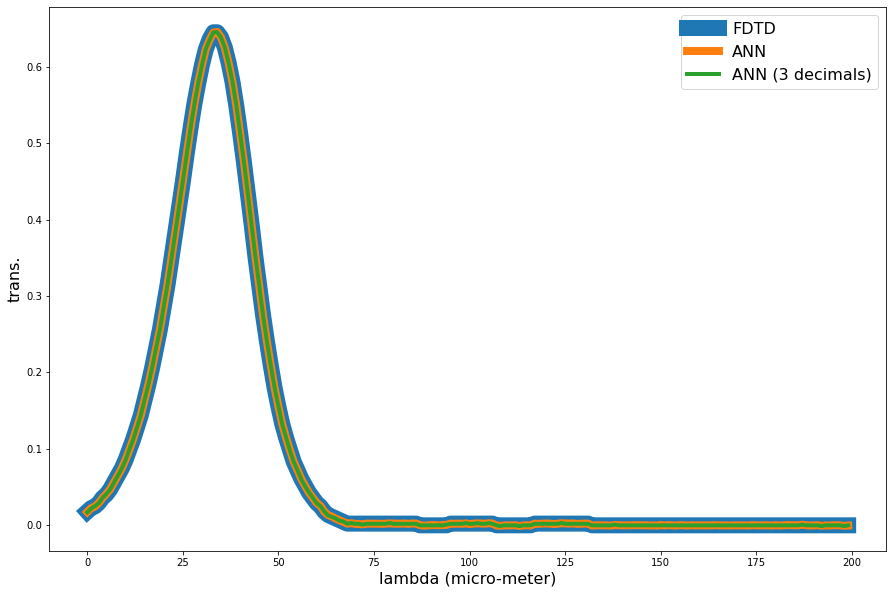

In [2339]:
example = 0

preds = np.flip(model.forward(x[example]).detach().numpy())
preds_rounded = np.flip(torch.round(model.forward(x[example]), decimals=SIG_FIGS).detach().numpy())
targets = np.flip(y[[example]].reshape(200).numpy())

plt.plot(targets, linewidth = 16, label="FDTD")
plt.plot(preds, linewidth = 8, label='ANN')
plt.plot(preds_rounded, linewidth = 4, label='ANN (3 decimals)')
plt.xlabel('lambda (micro-meter)', fontsize=16)
plt.ylabel('trans.', fontsize=16)
plt.legend(fontsize=16)